In [1]:
import pandas as pd
import numpy as np
import seaborn as sn

import matplotlib.pyplot as plt

import os
import string

import pycrfsuite

import nltk, re, pprint

from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Checks if token corresponds to a punctuation mark
def is_punctuation(token):
    return token in set(string.punctuation)

# Receives a word (token,postag,label) and converts it into a 
# feature that contains characteristics of it and if it applies
# contains also characteristics about the word before and after it.
# 'sent' correspond to the word in question and 'i' corresponds to the 
# index of the word in the sentence.
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'word.ispunct()': is_punctuation(word),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isdigit()': word1.isdigit(),
            '-1:word.ispunct()': is_punctuation(word1),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isdigit()': word1.isdigit(),
            '+1:word.ispunct()': is_punctuation(word1),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

# Converts every word (token,postag,label) into a feature, then returns
# the list of converted features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

# Extracts only the labels of the dataset, when the data is in the form: (token,pos,label)
# Returns a list of labels with the same structure as the dataset
def sent2labels(sent):
    return [label for token, postag, label in sent]

# Extracts only the tokens of the dataset, when the data is in the form: (token,pos,label)
# Returns a list of tokens with the same structure as the dataset
def sent2tokens(sent):
    return [token for token, postag, label in sent]


In [3]:
# Prepares the data to be used in the algorithm, converts every
# word into a feature and separates the labels from the data.
# Data format used: [[(token,postag,label),...],[...]]
def prepareDataCrF(train_data,test_data):
    
    X_train = [sent2features(s) for s in train_data]
    y_train = [sent2labels(s) for s in train_data]

    X_test = [sent2features(s) for s in test_data]
    y_test = [sent2labels(s) for s in test_data]
    
    return X_train,y_train,X_test,y_test

In [4]:
# Function that receives the parameters to send to the algorithm
# as well as the data that will be used to train the model.
def trainCrF(x_train,y_train,c1,c2,max_iterations):
    
    loss = [] # code added to store the loss of every iteration
    data_long = len(x_train)
    trainer = pycrfsuite.Trainer(verbose=False)

    trainer.set_params({
        'c1': c1,   # coefficient for L1 penalty
        'c2': c2,  # coefficient for L2 penalty
        'max_iterations': max_iterations, 

        'feature.possible_transitions': True
    })

    # We are feeding our training set to the algorithm here.
    for xseq, yseq in zip(x_train, y_train):
        trainer.append(xseq, yseq)
    
    trainer.train('model/vuelax-bad.crfsuite')
    
    crf_tagger = pycrfsuite.Tagger()
    crf_tagger.open('model/vuelax-bad.crfsuite')
    
    for iteration in trainer.logparser.iterations:
        loss.append(iteration['loss']/data_long)

    return crf_tagger, loss

In [5]:
# Generates a heatmap graph with the data provided.
# 'true_values' corresponds to the real labels of the data,
# 'pred' are the labels predicted by the model and 'values'
# are all the possible labels.
def heatmapGraph(true_values,pred,values):

    cm = confusion_matrix(true_values,pred, labels=values)
    ax= plt.subplot()
    sn.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
       
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Real Values")
        
    ax.xaxis.set_ticklabels(values)
    ax.yaxis.set_ticklabels(values)
    return
    
    

In [6]:
# Function that runs the model with the test data, it receives
# the model, the data as features (x_test) and the labels corresponding
# the data (y_test). It also generates the classification report
# and calls the heatmap graph function.
def testCrF(model,x_test,y_test):
    
    all_true, all_pred = [], []
    predictions = []

    for i in range(len(x_test)):
        all_true.extend(y_test[i])
        pred = model.tag(x_test[i])
        all_pred.extend(pred)
        predictions.append(pred)
    
    print(classification_report(all_true, all_pred, digits=4))
    heatmapGraph(all_true, all_pred, ['B','I','O'])
    return predictions

**Algorithm sources**

https://eli5.readthedocs.io/en/latest/tutorials/sklearn_crfsuite.html

https://dev.to/fferegrino/conditional-random-fields-in-python-sequence-labelling-part-4-5ei2


**Testing the algorithm with the data**

<ipython-input-8-788c9c94c338>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  datos = datos.groupby('sequence')['token','pos','ner_tag'].agg(list)


              precision    recall  f1-score   support

           B     0.9799    0.9739    0.9769      4261
           I     0.9480    0.8908    0.9185       348
           O     0.9933    0.9954    0.9943     22137

    accuracy                         0.9906     26746
   macro avg     0.9737    0.9534    0.9633     26746
weighted avg     0.9906    0.9906    0.9906     26746



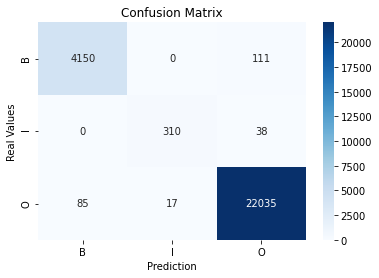

In [8]:
datos = pd.read_csv("data/atta_specimen_ner.csv",keep_default_na=False, na_values=[''])

datos = datos.groupby('sequence')['token','pos','ner_tag'].agg(list)


tokenList = datos['token'].tolist()
posList = datos['pos'].tolist()
tagList = datos['ner_tag'].tolist()

dataList = []
for x,y,z in zip(tokenList,posList,tagList):
    dataList.append(list(zip(x,y,z)))
    
trainData, testData = train_test_split(dataList, test_size=0.2, random_state = 42)

X_train,y_train,X_test,y_test = prepareDataCrF(trainData,testData)

model, loss = trainCrF(X_train,y_train,0.1,0.1,40)  

y_preds = testCrF(model,X_test,y_test)



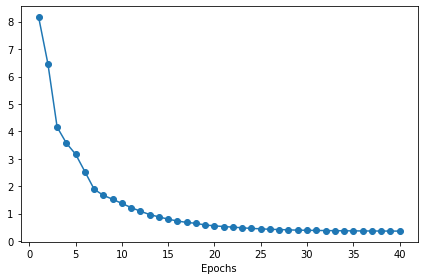

In [21]:
# Graph of the difference between the predicted labels and the real ones
# in each epoch.

plt.plot(range(1, len(loss) + 1), loss, marker='o')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [ ]:
# For to print the sentences in which there were errors, its printed as 
# (token,real label, predicted label)

for i in range(len(X_test)):
    if y_test[i] != y_preds[i]:
        
        lista_tokens = list(map(lambda x: x['word.lower()'],X_test[i]))
        print("Sentence:")
        print(list(zip(lista_tokens,y_test[i],y_preds[i])))
        